# 大模型训练相关实验分析

## 实验环境

### 软件环境

- 操作系统 Ubuntu 20.04
- torch 1.14
- cuda: 11.8

### 硬件环境

- CPU 96Core 3.00GHz 376GB RAM
- 显卡Nvidia A40，FP16 $149.7$ TFPS, FP32 $37.4$ TFPS，显存48GB

### GPU信息

GPU卡信息：
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:3F:00.0 Off |                    0 |
|  0%   30C    P8    21W / 300W |      0MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
```

**GPU拓扑1：**
```
	GPU0	GPU1	GPU2	GPU3	GPU4	GPU5	GPU6	GPU7	CPU Affinity	NUMA Affinity
GPU0	 X 	PIX	PXB	PXB	SYS	SYS	SYS	SYS	0-23,48-71	0
GPU1	PIX	 X 	PXB	PXB	SYS	SYS	SYS	SYS	0-23,48-71	0
GPU2	PXB	PXB	 X 	PXB	SYS	SYS	SYS	SYS	0-23,48-71	0
GPU3	PXB	PXB	PXB	 X 	SYS	SYS	SYS	SYS	0-23,48-71	0
GPU4	SYS	SYS	SYS	SYS	 X 	PIX	PXB	PXB	24-47,72-95	1
GPU5	SYS	SYS	SYS	SYS	PIX	 X 	PXB	PXB	24-47,72-95	1
GPU6	SYS	SYS	SYS	SYS	PXB	PXB	 X 	PXB	24-47,72-95	1
GPU7	SYS	SYS	SYS	SYS	PXB	PXB	PXB	 X 	24-47,72-95	1
```

**GPU拓扑2：**
```
	GPU0	GPU1	GPU2	GPU3	GPU4	GPU5	GPU6	GPU7	CPU Affinity	NUMA Affinity
GPU0	 X 	PIX	PIX	PIX	SYS	SYS	SYS	SYS	0-27,56-83	0
GPU1	PIX	 X 	PIX	PIX	SYS	SYS	SYS	SYS	0-27,56-83	0
GPU2	PIX	PIX	 X 	PIX	SYS	SYS	SYS	SYS	0-27,56-83	0
GPU3	PIX	PIX	PIX	 X 	SYS	SYS	SYS	SYS	0-27,56-83	0
GPU4	SYS	SYS	SYS	SYS	 X 	PIX	PIX	PIX	28-55,84-111	1
GPU5	SYS	SYS	SYS	SYS	PIX	 X 	PIX	PIX	28-55,84-111	1
GPU6	SYS	SYS	SYS	SYS	PIX	PIX	 X 	PIX	28-55,84-111	1
GPU7	SYS	SYS	SYS	SYS	PIX	PIX	PIX	 X 	28-55,84-111	1
```

**不同GPU链接方式速度：NV# > PIX > PXB > SYS**
```
Legend:

  X    = Self
  SYS  = Connection traversing PCIe as well as the SMP interconnect between NUMA nodes (e.g., QPI/UPI)
  NODE = Connection traversing PCIe as well as the interconnect between PCIe Host Bridges within a NUMA node
  PHB  = Connection traversing PCIe as well as a PCIe Host Bridge (typically the CPU)
  PXB  = Connection traversing multiple PCIe bridges (without traversing the PCIe Host Bridge)
  PIX  = Connection traversing at most a single PCIe bridge
  NV#  = Connection traversing a bonded set of # NVLinks
```

工具函数

In [3]:
from exp import *

In [2]:
def plot_metrics(metrics_dict: Dict):

    plot_data_dict = {}

    for name, metrics in compare_metrics.items():
        metrics: Metrics
        plot_data_dict[name] = {
            "forward-backward": f"{metrics.forward_backward: .2f}",
            "communication": f"{metrics.communication:.2f}",
            "memory": f"{metrics.memory}",
        }

    plot_data = pd.DataFrame(plot_data_dict).T

    print(plot_data)
    plot(plot_data)

In [3]:
def plot_metrics2(metrics_dict: Dict):

    plot_data_dict = {}

    for name, metrics in compare_metrics.items():
        metrics: Metrics
        plot_data_dict[name] = {
            "forward-backward": f"{metrics.forward_backward: .2f}",
            "communication": f"{metrics.communication:.2f}",
            "memory": f"{metrics.memory}",
            "samples_per_second": f"{metrics.samples_per_second}",
        }

    plot_data = pd.DataFrame(plot_data_dict).T

    print(plot_data)
    plot(plot_data)

## 模型参数量

GPT2、DOLLM实验模型参数量

|model|params|num_layers|hidden_size|num_head|
|---|----|---|----|---|
|gpt2-large|774M|36|1280|20|
|gpt2-xl|1558M|48|1600|25|
|dollm-6B|6064M|48|3200|40|
|dollm-13B|12848M|40|5120|40|

In [4]:
gpt2_large_model = LMConfig(num_layers=36, hidden_size=1280, num_attention_head=20)
gpt2_xl_model = LMConfig(num_layers=48, hidden_size=1600, num_attention_head=25)

## 混合精度训练（Mixed Precision Training）

论文：https://arxiv.org/abs/1710.03740

- 前向传播的参数Weight和反向传播的梯度Gradient使用半精度表示，优化器中的参数Weight、动量Moment使用单精度表示。
- 最新Nvidia计算架构FP16计算速度是FP32的两倍多，可以显著提升训练速度。

In [3]:
compare_exp = {
    "fp32": Config(gpus_per_node=1, steps=40, batch_size=3, fp16=False, activation_ckpt=False, lm=gpt2_large_model),
    "fp16": Config(gpus_per_node=1, steps=40, batch_size=3, fp16=True, activation_ckpt=False, lm=gpt2_large_model)
}
compare_metrics = {}

for name, cfg in compare_exp.items():
    train_model(cfg)
    metrics = parse_log("train.log")
    assert metrics is not None
    print_metrics(metrics, name)
    compare_metrics[name] = metrics

training model ......
fp32: forward-backward: 891.62 ms, optimizer: 67.51 ms, communication: 11.01 ms, compute/total ratio: 0.99, memory: 41,698 M
training model ......
fp16: forward-backward: 365.07 ms, optimizer: 67.87 ms, communication: 5.48 ms, compute/total ratio: 0.99, memory: 28,897 M


**实验结果：**
- forward-backward计算速度提升一倍多。
- 通信量降低50%。
- 显存绝对值减少了12801M，比例降低了30%（减少的主要是数据、中间变量占用的显存）。

混合精度训练显存占用分析（假设模型参数量是 $\Psi$）：

- 参数$2\Psi$（fp16）
- 梯度$2\Psi$（fp16）
- 优化器，**参数$4\Psi$（fp32）**，动量$2*4\Psi$（fp32）
- 数据、中间变量、buffer等

## Activation checkpoint

以计算换空间，重新计算前向传播的中间结果，降低显存占用。

In [4]:
compare_exp = {
    "fp32": Config(gpus_per_node=1, steps=40, batch_size=3, fp16=False, activation_ckpt=False, lm=gpt2_large_model),
    "fp16": Config(gpus_per_node=1, steps=40, batch_size=3, fp16=True, activation_ckpt=False, lm=gpt2_large_model),
    "fp16,act_ckpt": Config(gpus_per_node=1, steps=40, batch_size=3, fp16=True, activation_ckpt=True, lm=gpt2_large_model)
}
compare_metrics = {}

for name, cfg in compare_exp.items():
    train_model(cfg)
    metrics = parse_log("train.log")
    assert metrics is not None
    print_metrics(metrics, name)
    compare_metrics[name] = metrics


training model ......
fp32: forward-backward: 893.70 ms, optimizer: 66.45 ms, communication: 11.01 ms, compute/total ratio: 0.99, memory: 41,698 M
training model ......
fp16: forward-backward: 364.07 ms, optimizer: 67.88 ms, communication: 5.49 ms, compute/total ratio: 0.99, memory: 28,897 M
training model ......
fp16,act_ckpt: forward-backward: 421.77 ms, optimizer: 70.53 ms, communication: 5.49 ms, compute/total ratio: 0.99, memory: 18,165 M


              forward-backward communication memory
fp32                    893.70         11.01  41698
fp16                    364.07          5.49  28897
fp16,act_ckpt           421.77          5.49  18165


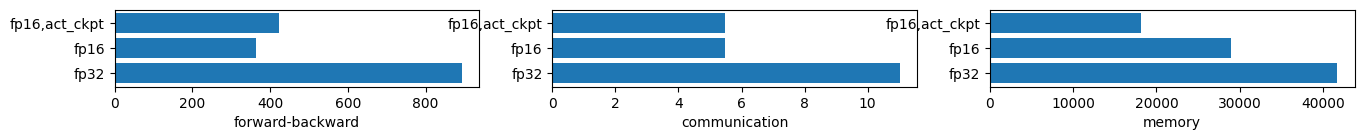

In [5]:
# 打印metrics，并绘制图标
plot_metrics(compare_metrics)

实验结果：
- forward-backward计算速度慢了13.68%。
- 通信量没有变化。
- **显存绝对值降低了10732M，比例降低了37.1%。**

> 以上实验结果fp16,act_ckpt相对fp16的变化值。
> 计算量增加20%左右。

## 数据并行（Data Parallel）

In [7]:
compare_exp = {
    "1dp": Config(gpus_per_node=1, steps=40, batch_size=4, fp16=True, activation_ckpt=False, lm=gpt2_large_model),
    "2dp": Config(gpus_per_node=2, steps=40, batch_size=4, fp16=True, activation_ckpt=False, lm=gpt2_large_model),
    "4dp": Config(gpus_per_node=4, steps=40, batch_size=4, fp16=True, activation_ckpt=False, lm=gpt2_large_model),
    "8dp": Config(gpus_per_node=8, steps=40, batch_size=4, fp16=True, activation_ckpt=False, lm=gpt2_large_model),
}

compare_metrics = {}

for name, cfg in compare_exp.items():
    train_model(cfg)
    metrics = parse_log("train.log")
    assert metrics is not None
    print_metrics(metrics, name)
    compare_metrics[name] = metrics


training model ......
fp16: forward-backward: 469.03ms, optimizer: 69.20ms, communication: 5.53ms, compute/total ratio: 0.99, memory: 34,565M samples_per_second: 71
training model ......
2dp: forward-backward: 468.72ms, optimizer: 68.20ms, communication: 78.98ms, compute/total ratio: 0.87, memory: 34,565M samples_per_second: 125
training model ......
4dp: forward-backward: 480.88ms, optimizer: 68.69ms, communication: 112.19ms, compute/total ratio: 0.83, memory: 34,565M samples_per_second: 221
training model ......
8dp: forward-backward: 502.77ms, optimizer: 69.19ms, communication: 360.47ms, compute/total ratio: 0.61, memory: 34,565M samples_per_second: 306


     forward-backward communication memory samples_per_second
fp16           469.03          5.53  34565                 71
2dp            468.72         78.98  34565                125
4dp            480.88        112.19  34565                221
8dp            502.77        360.47  34565                306


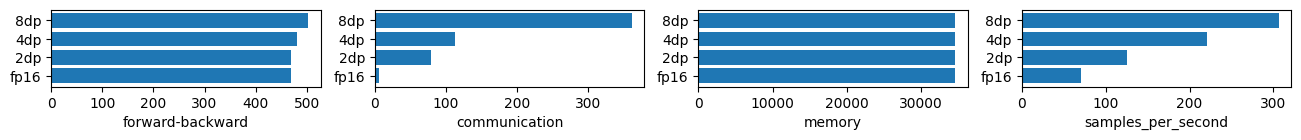

In [8]:
plot_metrics2(compare_metrics)

实验结果：
- forward-backward没有变化。
- **通信时间增加明显，尤其是从4路DP到8路DP，通信时间增长了2.21倍。**
- 显存没有变化。
- **每秒处理的样本数据随着数据并行增大而增大，但8路DP比4路DP才提升了50%（计算量翻了一倍，但速度仅快了38.4%，8路DP通信比例0.39过大）。**

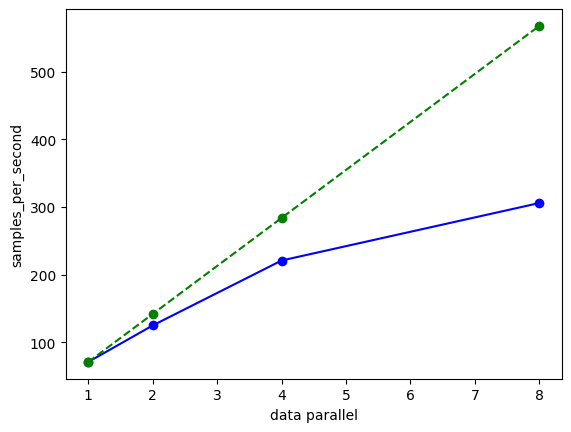

In [59]:
# 1路DP、2路DP、4路DP和8DP每秒处理样本数据对比。
def plot_dp_speed():
    x = [1, 2, 4, 8]
    y1 = [71, 125, 221, 306]
    y2 = [71, 142, 284, 568]

    fig, ax = plt.subplots()
    ax.plot(x, y1, 'ob-')
    ax.plot(x, y2, 'og--')
    ax.set_xlabel("data parallel")
    ax.set_ylabel("samples_per_second")

plot_dp_speed()

## 张量并行（Tensor Parallel）

## 流水线并行（Pipeline Parallel）